# Notes on oligopyrimidine regions:

- Pyrimidines: C, T/U
- NOT Pyrimidines: G, A

## Definitions of related motifs in different papers:

[Lim et al 2021 (Hsieh)](https://www.nature.com/articles/s41467-021-24445-6):
- 5'TOP: C at position 0, then at least 4 pyrimidines
- PTRE: according to PWM. can start at any position apparently

[Thoreen et al. 2012](https://www.nature.com/articles/nature11083):
- "TOP-like motif consisting of a stretch of at least five pyrimidines within four nucleotides of the most frequent TSS"

[Hsieh et al. 2012](https://www.nature.com/articles/nature10912):
- about PRTE: "consists of an invariant uridine at position 6 flanked by pyrimidines and, importantly, does not reside at position +1 of the 5′ UTR"

## About the expected effects:

Hsieh et al. 2012:
- "Phosphorylation of 4EBP1 by mTORC1 leads to its dissociation from eIF4E, allowing translation initiation complex formation at the 5′ end of mRNAs5. The mTOR-dependent phosphorylation of p70S6K1/2 also promotes translation initiation as well as elongation."
- "It has been previously shown that some mTOR translationally regulated mRNAs, most notably those involved in protein synthesis, possess a 5′ terminal oligopyrimidine tract (5′ TOP)14,15 that is regulated by distinct trans-acting factors"
- Conclusion: mTOR -> mRNAs with 5'TOP. If mTOR is hyperactive (which may be the case in a cancer cell line such as HEK293), we might expect increased activity of mRNAs with 5'TOP motifs or similar.

In [1]:
import os

import numpy
import matplotlib
from matplotlib import pyplot
import pandas
import scipy
import scipy.stats
import seaborn

In [2]:
%matplotlib inline
matplotlib.rcParams['figure.dpi'] = 120
matplotlib.rcParams['font.sans-serif'] = 'Helvetica'

In [3]:
# Combined replicates
datasets = [
    {
        'short_label': 'F25-N50',
        'filepath': '../polysome_profiling_sample2019/GSM3130435_egfp_unmod_1.csv.gz',
        'seq_len': 50,
        'const_prefix_len': 25,
        'color': '#009444',
        'linestyle': '-',
        'cols': ['utr', 'total_reads', 'rl'],
    },
    {
        'short_label': 'G3-N25',
        'filepath': '../polysome_profiling_data/random_end_hek293t_N25_combined.csv.gz',
        'seq_len': 25,
        'const_prefix_len': 3,
        'color': '#FBB040',
        'linestyle': '-',
        'cols': ['UTR', 'total', 'rl'],
    },
    {
        'short_label': 'G3-N50',
        'filepath': '../polysome_profiling_data/random_end_hek293t_N50_r1.csv.gz',
        'seq_len': 50,
        'const_prefix_len': 3,
        'color': '#F15A29',
        'linestyle': '-',
        'cols': ['UTR', 'total', 'rl'],
    },
]

In [4]:
# Load data
for dataset in datasets:
    
    data_table = pandas.read_csv(
        dataset['filepath'],
        usecols=dataset['cols'],
    )
    data_table = data_table.rename(columns={'utr': 'UTR', 'total_reads': 'total'})
    data_table = data_table[data_table['total'] > 100]
    
    dataset['data_table'] = data_table

## Analysis at every position

In [5]:
n_hypotheses = 0
for dataset in datasets:
    seq_len = dataset['seq_len']
    data_table = dataset['data_table']

    # # Filter - optional
    # data_table = data_table[~data_table['UTR'].str.contains('ATG')]
    # if dataset['short_label']=='F25-N50':
    #     data_table = data_table[~(data_table['UTR'].str[:2]=='TG')]

    top_like_len = 5
    top_like_n = numpy.zeros(seq_len - top_like_len + 1)
    top_like_mean_mrl = numpy.zeros(seq_len - top_like_len + 1)
    top_like_median_mrl = numpy.zeros(seq_len - top_like_len + 1)
    top_like_lowerperc_mrl = numpy.zeros(seq_len - top_like_len + 1)
    top_like_upperperc_mrl = numpy.zeros(seq_len - top_like_len + 1)
    top_like_pval = numpy.zeros(seq_len - top_like_len + 1)

    # First iteration to obtain sequences with no poly-T at any position
    top_like_idx = False
    for top_like_offset in range(seq_len - top_like_len + 1):
        # General U/C stretch
        top_like_idx |= \
            (~data_table['UTR'].str[top_like_offset: top_like_offset + top_like_len].str.contains('A')) &\
            (~data_table['UTR'].str[top_like_offset: top_like_offset + top_like_len].str.contains('G'))
        # PRTE
        # top_like_idx |= \
        #     (~data_table['UTR'].str[top_like_offset: top_like_offset + top_like_len].str.contains('A')) &\
        #     (~data_table['UTR'].str[top_like_offset: top_like_offset + top_like_len].str.contains('G')) &\
        #     (data_table['UTR'].str[top_like_offset + top_like_len//2 + 1]=='T')

    not_top_like_table = data_table[~top_like_idx]

    # Second round of iterations to separate seqs with poly-Ts at each position
    for top_like_offset in range(seq_len - top_like_len + 1):
        # General U/C stretch
        top_like_idx = \
            (~data_table['UTR'].str[top_like_offset: top_like_offset + top_like_len].str.contains('A')) &\
            (~data_table['UTR'].str[top_like_offset: top_like_offset + top_like_len].str.contains('G'))
        # PRTE
        # top_like_idx = \
        #     (~data_table['UTR'].str[top_like_offset: top_like_offset + top_like_len].str.contains('A')) &\
        #     (~data_table['UTR'].str[top_like_offset: top_like_offset + top_like_len].str.contains('G')) &\
        #     (data_table['UTR'].str[top_like_offset + top_like_len//2 + 1]=='T')
        top_like_table = data_table[top_like_idx]
        # not_top_like_table = data_table[~top_like_idx]

        # if top_like_offset==10:
        #     display(top_like_table)
        #     display(not_top_like_table)
        
        top_like_n[top_like_offset] = len(top_like_table)
        top_like_mean_mrl[top_like_offset] = top_like_table['rl'].mean()
        top_like_median_mrl[top_like_offset] = top_like_table['rl'].median()
        top_like_lowerperc_mrl[top_like_offset] = top_like_table['rl'].quantile(0.25)
        top_like_upperperc_mrl[top_like_offset] = top_like_table['rl'].quantile(0.75)
        top_like_pval[top_like_offset] = scipy.stats.mannwhitneyu(top_like_table['rl'], not_top_like_table['rl']).pvalue
        # top_like_pval[top_like_offset] = scipy.stats.mannwhitneyu(top_like_table['rl'], data_table['rl']).pvalue

    dataset['top_like_n'] = top_like_n
    dataset['top_like_mean_mrl'] = top_like_mean_mrl
    dataset['top_like_median_mrl'] = top_like_median_mrl
    dataset['top_like_lowerperc_mrl'] = top_like_lowerperc_mrl
    dataset['top_like_upperperc_mrl'] = top_like_upperperc_mrl
    dataset['top_like_pval'] = top_like_pval
    dataset['top_like_pos_cds'] = numpy.arange(seq_len - top_like_len + 1) - dataset['seq_len']
    dataset['top_like_pos_mrna'] = numpy.arange(seq_len - top_like_len + 1) + 1 + dataset['const_prefix_len']

    n_hypotheses += (seq_len - top_like_len + 1)

# Add bonferroni-corrected p-values
for dataset in datasets:
    dataset['top_like_pval_corrected'] = dataset['top_like_pval']*n_hypotheses

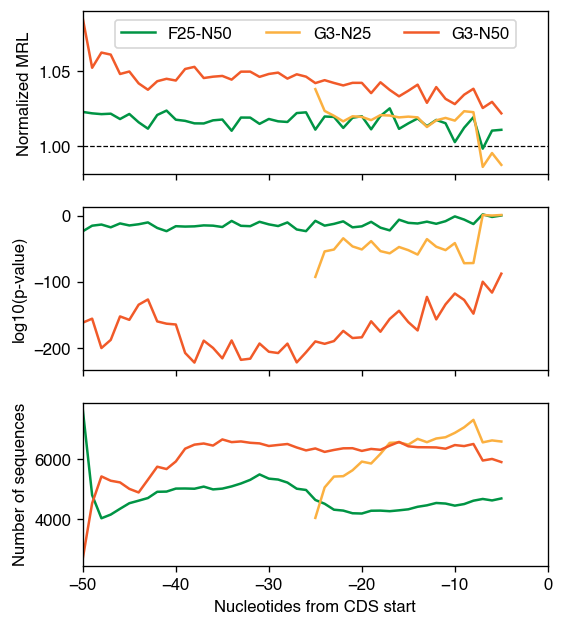

In [6]:
fig, axes = pyplot.subplots(3, 1, figsize=(5, 6))

# Plot MRL
ax = axes[0]
for dataset in datasets:
    ax.plot(
        dataset['top_like_pos_cds'],
        dataset['top_like_median_mrl']/dataset['data_table']['rl'].median(),
        label=dataset['short_label'],
        color=dataset['color'],
        linestyle=dataset['linestyle'],
    )
ax.axhline(1, color='black', linestyle='--', linewidth=0.75, zorder=-1)
ax.legend(ncol=len(datasets), loc='upper center')
# ax.set_xlabel('Nucleotides from CDS start')
ax.set_ylabel('Normalized MRL')
ax.set_xlim(-50, 0)
ax.xaxis.set_major_locator(pyplot.MultipleLocator(base=10))
ax.set_xticklabels([])

# Plot p-value
ax = axes[1]
for dataset in datasets:
    ax.plot(
        dataset['top_like_pos_cds'],
        # numpy.log10(dataset['top_like_pval']),
        numpy.log10(dataset['top_like_pval_corrected']),
        label=dataset['short_label'],
        color=dataset['color'],
        linestyle=dataset['linestyle'],
    )
# ax.axhline(0, color='grey', linewidth=0.75, zorder=-1)
# ax.axhline(-2, color='grey', linewidth=0.75, zorder=-1)
# ax.set_xlabel('Nucleotides from CDS start')
ax.set_ylabel('log10(p-value)')
ax.set_xlim(-50, 0)
ax.xaxis.set_major_locator(pyplot.MultipleLocator(base=10))
ax.set_xticklabels([])

# Plot number of sequences
ax = axes[2]
for dataset in datasets:
    ax.plot(
        dataset['top_like_pos_cds'],
        dataset['top_like_n'],
        label=dataset['short_label'],
        color=dataset['color'],
        linestyle=dataset['linestyle'],
    )
ax.set_ylabel('Number of sequences')
ax.set_xlabel('Nucleotides from CDS start')
ax.set_xlim(-50, 0)
ax.xaxis.set_major_locator(pyplot.MultipleLocator(base=10))

fig.savefig(f"polypirimidine_cds.svg", dpi=200, bbox_inches='tight')

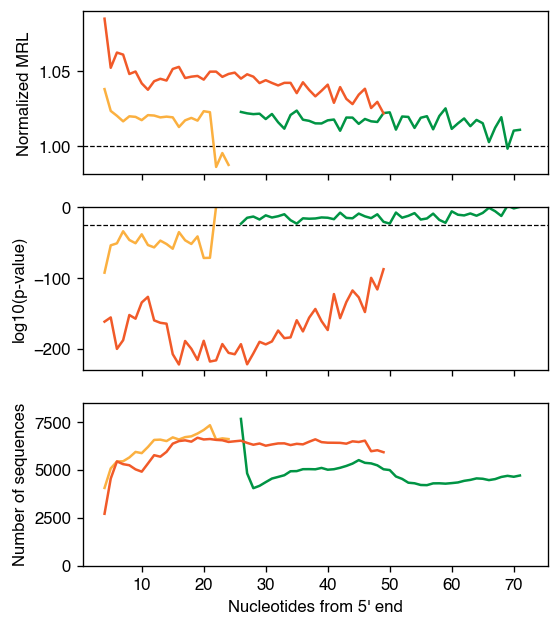

In [7]:
fig, axes = pyplot.subplots(3, 1, figsize=(5, 6))

# Plot MRL
ax = axes[0]
for dataset in datasets:
    ax.plot(
        dataset['top_like_pos_mrna'],
        dataset['top_like_median_mrl']/dataset['data_table']['rl'].median(),
        label=dataset['short_label'],
        color=dataset['color'],
        linestyle=dataset['linestyle'],
    )
    # ax.fill_between(
    #     dataset['top_like_pos_mrna'],
    #     dataset['top_like_lowerperc_mrl']/dataset['data_table']['rl'].median(),
    #     dataset['top_like_upperperc_mrl']/dataset['data_table']['rl'].median(),
    #     color=dataset['color'],
    #     alpha=0.3,
    # )
ax.axhline(1, color='black', linestyle='--', linewidth=0.75, zorder=-1)
# ax.legend(ncol=len(datasets), loc='upper center')
# ax.set_xlabel('Nucleotides from 5\' end')
ax.set_ylabel('Normalized MRL')
ax.set_xlim(0.5, 75.5)
ax.xaxis.set_major_locator(pyplot.MultipleLocator(base=10))
ax.set_xticklabels([])

# Plot p-value
ax = axes[1]
for dataset in datasets:
    ax.plot(
        dataset['top_like_pos_mrna'],
        # numpy.log10(dataset['top_like_pval']),
        numpy.log10(dataset['top_like_pval_corrected']),
        label=dataset['short_label'],
        color=dataset['color'],
        linestyle=dataset['linestyle'],
    )
# ax.axhline(0, color='grey', linewidth=0.75, zorder=-1)
ax.axhline(-25, color='k', linestyle='--', linewidth=0.75, zorder=-1)
# ax.set_xlabel('Nucleotides from 5\' end')
ax.set_ylabel('log10(p-value)')
ax.set_xlim(0.5, 75.5)
ax.set_ylim(-230, 0)
ax.xaxis.set_major_locator(pyplot.MultipleLocator(base=10))
ax.set_xticklabels([])

# Plot number of sequences
ax = axes[2]
for dataset in datasets:
    ax.plot(
        dataset['top_like_pos_mrna'],
        dataset['top_like_n'],
        label=dataset['short_label'],
        color=dataset['color'],
        linestyle=dataset['linestyle'],
    )
ax.set_ylabel('Number of sequences')
ax.set_xlabel('Nucleotides from 5\' end')
ax.set_xlim(0.5, 75.5)
ax.xaxis.set_major_locator(pyplot.MultipleLocator(base=10))
ax.set_ylim(0, 8500)

fig.savefig(f"polypirimidine_mrna.svg", dpi=200, bbox_inches='tight')

## Analysis at position 1 vs the others

For dataset F25-N50:
# seqs: 308,268, median MRL: 7.12
# seqs with a polypirimidine anywhere: 108,082, median MRL: 7.20, normalized: 1.01
# seqs with polypirimidine tract at position 1: 7,650, median MRL: 7.28, normalized: 1.02
# seqs with polypirimidine tract at position 2 or after: 104,990, median MRL: 7.20, normalized: 1.01
# seqs with no polypirimidine tract: 200,186, median MRL: 7.06, normalized: 0.99
Polypirimidine anywhere vs None: 7.20 vs 7.06, p-value = 1.50e-119
Polypirimidine at position 1 vs None: 7.28 vs 7.06, p-value = 2.33e-25
Polypirimidine at position 2 or after vs None: 7.20 vs 7.06, p-value = 5.05e-118
Polypirimidine at position 1 vs 2 or after: 7.28 vs 7.20, p-value = 1.63e-02

For dataset G3-N25:
# seqs: 167,245, median MRL: 6.28
# seqs with a polypirimidine anywhere: 58,741, median MRL: 6.36, normalized: 1.01
# seqs with polypirimidine tract at position 1: 4,051, median MRL: 6.52, normalized: 1.04
# seqs with polypirimidine tract at position 2 or after: 57,251, me

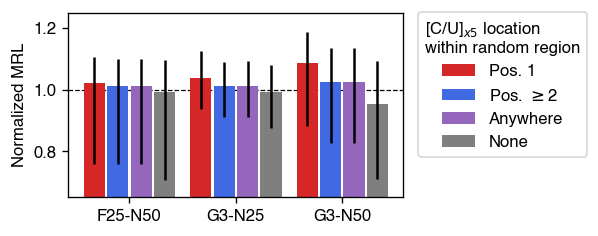

In [8]:
fig, ax = pyplot.subplots(figsize=(1.2*len(datasets), 2))
fill_colors = ['tab:red', 'royalblue', 'tab:purple', 'tab:grey']
pval_correction_factor = 4*len(datasets)

for dataset_idx, dataset in enumerate(datasets):
    seq_len = dataset['seq_len']
    data_table = dataset['data_table']

    # # Filter - optional
    # data_table = data_table[~data_table['UTR'].str.contains('ATG')]
    # if dataset['short_label']=='F25-N50':
    #     data_table = data_table[~(data_table['UTR'].str[:2]=='TG')]

    top_like_len = 5

    top_like_pos1_end_idx = False
    for top_like_offset in range(seq_len - top_like_len + 1):
        # General U/C stretch
        top_like_idx = \
            (~data_table['UTR'].str[top_like_offset: top_like_offset + top_like_len].str.contains('A')) &\
            (~data_table['UTR'].str[top_like_offset: top_like_offset + top_like_len].str.contains('G'))

        # PRTE
        # top_like_idx = \
        #     (~data_table['UTR'].str[top_like_offset: top_like_offset + top_like_len].str.contains('A')) &\
        #     (~data_table['UTR'].str[top_like_offset: top_like_offset + top_like_len].str.contains('G')) &\
        #     (data_table['UTR'].str[top_like_offset + top_like_len//2 + 1]=='T')

        if top_like_offset==0:
            top_like_pos0_idx = top_like_idx
        else:
            top_like_pos1_end_idx |= top_like_idx
    
    top_like_pos0_table = data_table[top_like_pos0_idx]
    top_like_pos1_end_table = data_table[top_like_pos1_end_idx]
    top_like_table = data_table[top_like_pos0_idx|top_like_pos1_end_idx]
    not_top_like_table = data_table[~(top_like_pos0_idx|top_like_pos1_end_idx)]

    # Print stats
    print(f"For dataset {dataset['short_label']}:")
    print("# seqs: {:,}, median MRL: {:.2f}".format(
        len(data_table),
        data_table['rl'].median(),
    ))
    print("# seqs with a polypirimidine anywhere: {:,}, median MRL: {:.2f}, normalized: {:.2f}".format(
        len(top_like_table),
        top_like_table['rl'].median(),
        top_like_table['rl'].median() / data_table['rl'].median()
    ))
    print("# seqs with polypirimidine tract at position 1: {:,}, median MRL: {:.2f}, normalized: {:.2f}".format(
        len(top_like_pos0_table),
        top_like_pos0_table['rl'].median(),
        top_like_pos0_table['rl'].median() / data_table['rl'].median()
    ))
    print("# seqs with polypirimidine tract at position 2 or after: {:,}, median MRL: {:.2f}, normalized: {:.2f}".format(
        len(top_like_pos1_end_table),
        top_like_pos1_end_table['rl'].median(),
        top_like_pos1_end_table['rl'].median() / data_table['rl'].median()
    ))
    print("# seqs with no polypirimidine tract: {:,}, median MRL: {:.2f}, normalized: {:.2f}".format(
        len(not_top_like_table),
        not_top_like_table['rl'].median(),
        not_top_like_table['rl'].median() / data_table['rl'].median()
    ))
    print("Polypirimidine anywhere vs None: {:.2f} vs {:.2f}, p-value = {:.2e}".format(
        top_like_table['rl'].median(),
        not_top_like_table['rl'].median(),
        scipy.stats.mannwhitneyu(top_like_table['rl'], not_top_like_table['rl']).pvalue*pval_correction_factor
    ))
    print("Polypirimidine at position 1 vs None: {:.2f} vs {:.2f}, p-value = {:.2e}".format(
        top_like_pos0_table['rl'].median(),
        not_top_like_table['rl'].median(),
        scipy.stats.mannwhitneyu(top_like_pos0_table['rl'], not_top_like_table['rl']).pvalue*pval_correction_factor
    ))
    print("Polypirimidine at position 2 or after vs None: {:.2f} vs {:.2f}, p-value = {:.2e}".format(
        top_like_pos1_end_table['rl'].median(),
        not_top_like_table['rl'].median(),
        scipy.stats.mannwhitneyu(top_like_pos1_end_table['rl'], not_top_like_table['rl']).pvalue*pval_correction_factor
    ))
    print("Polypirimidine at position 1 vs 2 or after: {:.2f} vs {:.2f}, p-value = {:.2e}".format(
        top_like_pos0_table['rl'].median(),
        top_like_pos1_end_table['rl'].median(),
        scipy.stats.mannwhitneyu(top_like_pos0_table['rl'], top_like_pos1_end_table['rl']).pvalue*pval_correction_factor
    ))
    print()

    # Plot
    x = [dataset_idx - 0.33, dataset_idx - 0.11, dataset_idx + 0.11, dataset_idx + 0.33]
    dfs_to_plot = [top_like_pos0_table, top_like_pos1_end_table, top_like_table, not_top_like_table]

    # bp = ax.boxplot(
    #     [df['rl'].values/data_table['rl'].median() for df in dfs_to_plot],
    #     positions=x,
    #     whis=0,
    #     showcaps=False,
    #     showfliers=False,
    #     patch_artist=True,
    # )
    # pyplot.setp(bp['medians'], color='k')
    # for fill_color, patch in zip(fill_colors, bp['boxes']):
    #     patch.set(facecolor=fill_color)
    y = []
    yerr = [[], []]
    for df in dfs_to_plot:
        y.append(df['rl'].median()/data_table['rl'].median())
        yerr[0].append((df['rl'].median() - df['rl'].quantile(0.25))/data_table['rl'].median())
        yerr[1].append((df['rl'].quantile(0.75) - df['rl'].median())/data_table['rl'].median())
    ax.bar(
        x, y, yerr=yerr,
        width=0.2,
        color=fill_colors,
    )

ax.set_xticks(range(len(datasets)))
ax.set_xticklabels([d['short_label'] for d in datasets])
ax.axhline(1, color='black', linestyle='--', linewidth=0.75, zorder=-1)
ax.set_ylabel('Normalized MRL')
ax.set_ylim(0.65, 1.25)

legend_elements = [
    matplotlib.patches.Patch(facecolor=fill_colors[0], label='Pos. 1'),
    matplotlib.patches.Patch(facecolor=fill_colors[1], label='Pos. $\\geq$2'),
    matplotlib.patches.Patch(facecolor=fill_colors[2], label='Anywhere'),
    matplotlib.patches.Patch(facecolor=fill_colors[3], label='None'),
]
ax.legend(handles=legend_elements, title='[C/U]$_{x5}$ location\nwithin random region', bbox_to_anchor=(1.02, 1.05))
fig.savefig(f"polypirimidine_pos1.svg", dpi=200, bbox_inches='tight')